Most codes adapted from Fall23_BusinessAnalytics_ModelEvaluation.ipynb by Prof. Vilma Todri.

## Data Loading

In [1]:
# read data from http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

import pandas as pd
import numpy as np

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

df.columns = ['id', 'diagnosis', 'radius_mean',  'texture_mean',  'perimeter_mean',  'area_mean',  'smoothness_mean',  'compactness_mean',  'concavity_mean',  'concave_points_mean',  'symmetry_mean',  'fractal_dimension_mean',
                                 'radius_se',    'texture_se',    'perimeter_se',    'area_se',    'smoothness_se',    'compactness_se',    'concavity_se',    'concave_points_se',    'symmetry_se',    'fractal_dimension_se',
                                 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

In [2]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# 1. Preprocessing
# 1.1. Convert diagnosis to binary
df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})

# 1.2. Split data into training, validation and test sets
from sklearn.model_selection import train_test_split
X = df.iloc[:, 2:]
y = df.iloc[:, 1]


# prep high-correlated features dropped data for logistic regression
# Calculate the correlation of each feature (except first two columns) with the target variable
correlation_with_target = df.iloc[:, 2:].corrwith(df['diagnosis']).abs()

# Create the correlation matrix for all columns except the first two
corrmatrix = df.iloc[:, 2:].corr().abs()

# Get pairs of highly correlated features
high_corr_var = np.where(corrmatrix > 0.9)
high_corr_var = [(corrmatrix.columns[x], corrmatrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Drop one of each pair based on correlation with target
for var1, var2 in high_corr_var:
    if correlation_with_target[var1] > correlation_with_target[var2]:
        df.drop(var2, axis=1, inplace=True, errors='ignore')
    else:
        df.drop(var1, axis=1, inplace=True, errors='ignore')

X_dropped = df.iloc[:,2:]

In [4]:
np.random.seed(42) # ensure reproducability

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(X_dropped, y, test_size=0.3, random_state=42)

## Modeling

In [6]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, datasets
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
# Pipeline of transforms with a final estimator
from sklearn.pipeline import Pipeline

Decision Tree

In [7]:
# build decision tree classifier to predict whether the breast cancer is benign or malignant in df
#Using the nested cross-validation technique, try to optimize the parameters of your Decision Tree classifiers in order to improve the performance of your classifiers (i.e., f1-score) as much as possible

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42) # inner cross-validation folds
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42) # outer cross-validation folds


# 2. Nested cross-validation
# Choosing optimal depth of the tree AND optimal splitting criterion
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': range(1,10),
                               'criterion':['gini','entropy']}],
                  scoring='f1',
                  cv=inner_cv
                 )

gs_dt = gs_dt.fit(X,y)
print("Non-nested CV f1: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)

print('Nested F1 score:', cross_val_score(gs_dt, X=X, y=y, cv=outer_cv, scoring='f1').mean(), " +/- ", cross_val_score(gs_dt, X=X, y=y, cv=outer_cv, scoring='f1').std())

Non-nested CV f1:  0.9291318047132
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 4}
Optimal Estimator:  DecisionTreeClassifier(max_depth=4, random_state=42)
Nested F1 score: 0.9313399043313317  +/-  0.01755355096715601


kNN

In [8]:

#Normalize Data
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('knn', KNeighborsClassifier(p=2,
                                     metric='minkowski'))
      ])

#Parameters to optimize:  k for number of nearest neighbors AND type of distance

params = {
        'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
        'knn__weights': ['uniform', 'distance']
    }

gs_knn2 = GridSearchCV(estimator=pipe,
                  param_grid=params,
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=1)

gs_knn2 = gs_knn2.fit(X,y)
print("Non-nested CV Accuracy: ", gs_knn2.best_score_)
print("Optimal Parameter: ", gs_knn2.best_params_)
print("Optimal Estimator: ", gs_knn2.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score

print('Nested F1 score:', cross_val_score(gs_knn2, X=X, y=y, cv=outer_cv, scoring='f1').mean(), " +/- ", cross_val_score(gs_knn2, X=X, y=y, cv=outer_cv, scoring='f1').std())

Non-nested CV Accuracy:  0.9523682840047905
Optimal Parameter:  {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])
Nested F1 score: 0.9450774508002675  +/-  0.03136189292189269


Logistics Regression

In [9]:
#To ignore the convergence warnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Choosing C parameter for Logistic Regression AND type of penalty (ie., l1 vs l2)
# See other parameters here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
gs_lr2 = GridSearchCV(estimator=LogisticRegression(solver='liblinear', random_state=42),
                  param_grid=[{'C': [ 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000],
                              'penalty':['l1','l2']}],
                  scoring='f1',
                  cv=inner_cv)

gs_lr2 = gs_lr2.fit(X,y)

print("Non-nested CV Accuracy: ", gs_lr2.best_score_)
print("Optimal Parameter: ", gs_lr2.best_params_)
print("Optimal Estimator: ", gs_lr2.best_estimator_)

nested_score_gs_lr2_f1 = cross_val_score(gs_lr2, X=X_dropped, y=y, cv=outer_cv, scoring='f1')
print('Nested F1 score:', nested_score_gs_lr2_f1.mean(), " +/- ", nested_score_gs_lr2_f1.std())

Non-nested CV Accuracy:  0.9576785075389728
Optimal Parameter:  {'C': 100, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')
Nested F1 score: 0.9691771009674287  +/-  0.025533311151298282


## learning curve

In [10]:
# b)	Build and visualize a learning curve for the logistic regression technique (visualize the performance for both training and test data in the same plot).

from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,        # data science algorithm
                        title,            # title of the plot
                        X, y,             # data (features and target variable)
                        ylim=None,        # minimum and maximum y values plotted
                        cv=None,          # cross validation splits
                        n_jobs=1,         # parallell estimation using multiple processors
                        train_sizes=np.linspace(.1, 1.0, 10)): #linspace returns evenly spaced numbers over a specified interval (start, stop, num)

        # Initialization of Figure
    plt.figure()                    # display figure

    # Titles/labels for the plot are set
    plt.title(title)                # specify title based on parameter provided as input
    if ylim is not None:            # if ylim was specified as an input, make sure the plots use these limits
        plt.ylim(*ylim)
    plt.xlabel("Training examples") # y label title
    plt.ylabel("F-1 Score")             # x label title

    # Learning Curve Calculation
    train_sizes, train_scores, test_scores = learning_curve(estimator, # data science algorithm
                                                            X_dropped, y,      # data (features and target variable)
                                                            cv=cv,     # cross-validation folds
                                                            scoring='f1_macro',
                                                            n_jobs=n_jobs, # number of jobs to run in parallel using multiple processors
                                                            train_sizes=train_sizes) # relative or absolute numbers of training examples
                                                                                     # that will be used to generate the learning curve

    # Score Calculations
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis.

    # Visualization of Learning Curve
    plt.grid()                                        # configure the grid lines in the plot
                                                      # adds grid lines to the plot for better visualization and understanding of the data points

    # Fill Between Scores to Indicate Standard Deviation
    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    # The area filled represents one standard deviation above and below the mean of the training/test scores
    plt.fill_between(train_sizes,                            # the x coordinates of the nodes defining the curves
                     train_scores_mean - train_scores_std,   # the y coordinates of the nodes defining the first curve
                     train_scores_mean + train_scores_std,   # the y coordinates of the nodes defining the second curve
                     alpha=0.1,                              # level of transparency in the color fill
                     color="r")                              # train data performance indicated with red
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")                              # test data performance indicated with green

    # Plotting the Mean Scores
    # Cross-validation mean scores indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes,                                    # the horizontal coordinates of the data points
             train_scores_mean,                              # the vertical coordinates of the data points
             'o-',                                           # o- will produce a small circle and a solid line to connect the markers
             color="r",                                      # line of red color
             label="Training score")                         # specify label title for this plot

    # Test data performance indicated with green
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",                                      # line of green color
             label="Testing (cross validation) score")

    plt.legend(loc="best")                      # show legend of the plot at the best location possible
                                                # placing it in the "best" location based on where matplotlib thinks it will least overlap with other elements
    return plt                                  # function that returns the plot as an output

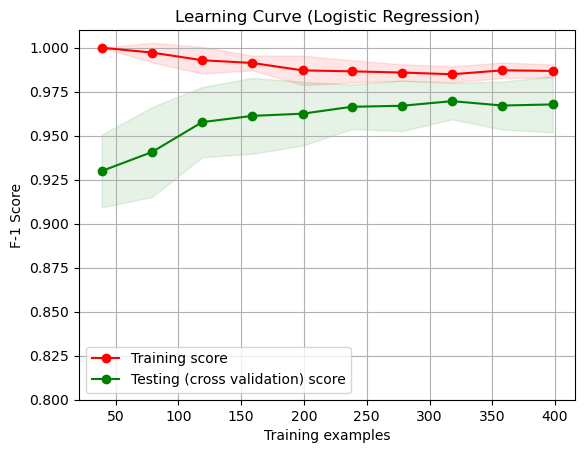

In [11]:
########################### Visualization of Learning Curves ###########################

# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure,
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt

# Defines the title for the learning curve of the Logistic Regression
title = "Learning Curve (Logistic Regression)"

# Initializes the ShuffleSplit cross-validator & an instance of the logistic regression model
# Class ShuffleSplit is a random permutation cross-validator
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.3
                  ,random_state=42)      # the seed used by the random number generator
estimator = LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')             # build multiple LR models as we increase the size of the traning data -------- edited to result of a

# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X, y,           # data (features and target variable)
                    (0.8, 1.01),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=1)       # parallell estimation using multiple processors (ie., 4 cores here)

plt.show()                          # display the figure

## fitting graph

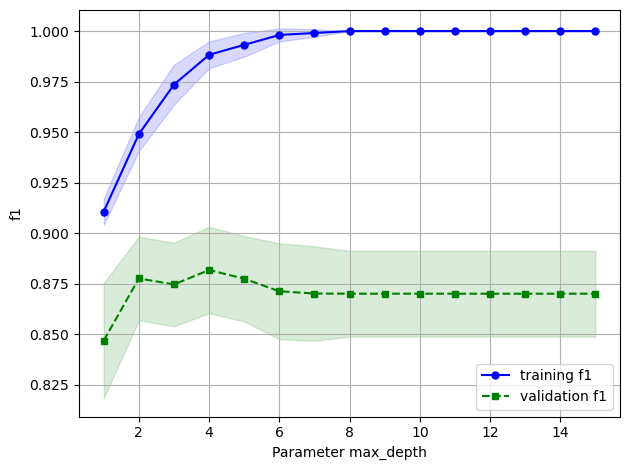

In [12]:
#c)	Build a fitting graph for different depths of the decision tree (visualize the performance for both training and test data in the same plot). Please provide screenshots of your code and explain the process you have followed.

############################### Import Libraries & Modules #################################

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split
# Class for Logistic Regression classifier

############################# Parameters - Varying Complexity #############################

param_range = range(1,16)

# Compute scores for an estimator with different values of a specified parameter.
# This is similar to grid search with one parameter.
# However, this will also compute training scores and is merely a utility for plotting the results.

########################## Estimate Scores - Varying Complexity ##########################

# Determine training and test scores for varying parameter values.
# sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html
train_scores, test_scores = validation_curve(
                estimator=DecisionTreeClassifier(random_state=42),
                X=X_train,                                    # data (features)
                y=y_train,                                    # target variable
                param_name="max_depth",
                param_range=param_range,                      # the values of the parameter that will be evaluated

                cv=cv,                                        # 10-fold cross-validation
                scoring="f1",                           # evaluation metric
                n_jobs=1)         # number of CPU cores used when parallelizing over classes if multi_class=’ovr’”.
                                  # this parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of
                                  # whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.

# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis (train data)
train_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis (train data)
test_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis (test data)
test_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis (test data)

############################## Visualization - Fitting Graph ##############################

# Plot train f1 means of cross-validation for all the parameters C in param_range
plt.plot(param_range,                     # the horizontal coordinates of the data points
         train_mean,                      # the vertical coordinates of the data points
         color='blue',                    # aesthetic parameter - color
         marker='o',                      # aesthetic parameter - marker
         markersize=5,                    # aesthetic parameter - size of marker
         label='training f1')       # specify label title

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range,             # the x coordinates of the nodes defining the curves
                 train_mean + train_std,  # the y coordinates of the nodes defining the first curve
                 train_mean - train_std,  # the y coordinates of the nodes defining the second curve
                 alpha=0.15,              # level of transparency in the color fill
                 color='blue')            # aesthetic parameter - color

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,
         test_mean,
         color='green',
         linestyle='--',
         marker='s',
         markersize=5,
         label='validation f1')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('f1')
#plt.ylim([0.9, 1.0]) # y limits in the plot
plt.tight_layout()
#plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()                            # display the figure


## ROC curve

10-fold cross validation:

ROC AUC: 0.9968 (+/- 0.0035) [Logistic regression]
ROC AUC: 0.9184 (+/- 0.0657) [Decision tree]
ROC AUC: 0.9897 (+/- 0.0117) [kNN]


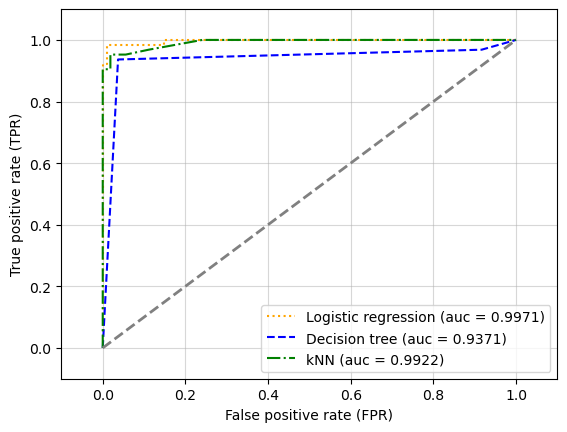

In [13]:
#d)	Create an ROC curve for k-NN, decision tree, and logistic regression

############################### Import Libraries & Modules #################################

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

######################################## Classifiers ########################################
# Logistic Regression Classifier                                                 ---------------------------------------- replaced wtih result of a
clf1 = LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')

# Decision Tree Classifier
clf2 =DecisionTreeClassifier(max_depth=4, random_state=42)

# kNN Classifier

clf3 = Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

#################################### Cross - Validation ####################################

print('10-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers
    if label == 'Logistic regression':
        scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                             X=X_dropped,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    else:
        scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                                X=X,
                                y=y,
                                cv=10,
                                scoring='roc_auc')
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    if label == 'Logistic regression':

      # Assuming the label of the positive class is 1 and data is normalized
      y_pred = clf.fit(X_dropped_train, y_dropped_train).predict_proba(X_dropped_test)[:, 1] # make predictions based on the classifiers

      fpr, tpr, thresholds = roc_curve(y_true=y_dropped_test,       # build ROC curve
                                      y_score=y_pred)
      roc_auc = auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC)
      plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
              color=clr,
              linestyle=ls,
              label='%s (auc = %0.4f)' % (label, roc_auc))
    else:
      y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers

      fpr, tpr, thresholds = roc_curve(y_true=y_test,       # build ROC curve
                                      y_score=y_pred)
      roc_auc = auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC)
      plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
              color=clr,
              linestyle=ls,
              label='%s (auc = %0.4f)' % (label, roc_auc))

plt.legend(loc='lower right')    # where to place the legend
plt.plot([0, 1], [0, 1],         # visualize random classifier
         linestyle='--',         # aesthetic parameters
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()